In [1]:
#| export
print_flag                    = True
check_memory_usage            = True
time_flag                     = True
window_size_percentage        = False
show_plots                    = True
reset_kernel                  = True
pre_configured_case           = False
case_id                       = 1
frequency_factor              = 5
frequency_factor_change_alias = True
check_parameters              = True
cuda_device                   = 0

TODO: 

**Python** [22 mayo]

1) [Hecho] **Corregir orientación**. Dar opción a dar la vuelta al eje y del MPlot al plotear (flag show_as_matlab).
   - np.flip(axis=0)
    
3) [Hecho] **Añadir filtros**. Añadir un parámetro filter : Callable en MatrixProfilePlot que por defecto tenga la identidad que permita pasar un filtro a la matriz de distancias antes de plotearla.
4) [In progress] **Crear un filtro versátil que permite seguir el enunciado**. Hacer una función de filtro para: Usar un valor threshold_min threshold_max (values) include_threshold_min include_threshold_max (flags) para mostrar sólo las distancias con valor en (threshold_min, threshold_max). Ver cómo gestiona eso imagesc de matlab, que no entiendo por qué a ellos no le sale la línea blanca del exclusion_zone = 8.
   (¿Quizá venga bien también en el MatrixProfile?)
    Algo pasa que no consigo sacar las líneas "zebra" aunque la orientación ya sea la correcta y los índices sean los mismos. Siguientes pasos:
    - Avisar a Zach de que SCAMP devuelve todo a 0 en el matrix profile ¿problemas con el exclusion_zone o con los 0's? ¿Faltaria un exclude_trivials? Añadir yo el exclude_trivials en lugar de poner scamp_naive que queda extraño
    - Añadir opción de plot en blanco y negro
    - Comprobar el filtro con el ejemplo en blanco y negro
    - Comprobar de nuevo el zoom, verificando que los límites estén puestos en los ejes concretos
    - ¿¿¿ Por qué el plot que he generado en blanco y negro con chatgpt sí que pone la matriz directamente en el mismo sentido que MATLAB???
6) **Corregir exclusion_zone**. Revisar que realmente estoy usando bien el exclusion zone. Asegurarme de que no lo aplico dos veces con STUMP. (Y, si lo estoy aplicando dos veces, comprobar indempotencia y me hago un 2 x 1 de saber que lo estoy haciendo bien).
7) **Comprobar zoom**. Comprobar que el zoom en la zona del artículo (o, sospecho 5k más a la derecha de lo que aparenta), sale el paso de cebra que busco.

**R** (1 semana máximo) [31 mayo]

1) **Ubicar**. Añadir UI y SERVER siguiendo la ventana que pinté en la Biblia de los MPlots.
2) **Implementar llamada**. Llamar a las funciones con filtros y ver que todo fluye
3) **Añadir los 4 plots** (TSA, TSB, MP, MPlot)
4) **Añadir interactividad entre los 4 plots**

**Back to python** [14 junio]

1) Comprobar posibles variables basadas en MatrixProfile o MPlot
   Ej. Probar a meter los k puntos más altos o los k puntos más bajos (patterns/discords)
3) Ver cómo afectan al entrenamiento del MVP

**Paper** [21 junio]

Redactar los descubrimientos

**Reunión VDM** [Mediados julio]

... En los ratos libres habría que arreglar la versión MatrixProfilePlotCached para no recalcular siempre ...


# MPlot

The MPlot is used to check the distance between subsequence pairs into a time series according to a window size. This notebooks tries to: generate the Mplot for a time series


In [2]:
if check_parameters:
    print("--- Check parameters ---")
    print(
        " print_flag:", print_flag, "\n",
        "check_memory_usage", check_memory_usage, "\n",
        "time_flag:", time_flag, "\n",
        "window_size_percentage:" , window_size_percentage, "\n",
        "show_plots:",show_plots, "\n",
        "reset_kernel:",reset_kernel, "\n",
        "pre_configured_case:",pre_configured_case, "\n",
        "case_id:",case_id, "\n",
        "frequency_factor:", frequency_factor,  "\n",
        "frequency_factor_change_alias", frequency_factor_change_alias, "\n",
        "cuda_device", cuda_device, "\n"
)

--- Check parameters ---
 print_flag: True 
 check_memory_usage True 
 time_flag: True 
 window_size_percentage: False 
 show_plots: True 
 reset_kernel: True 
 pre_configured_case: False 
 case_id: 1 
 frequency_factor: 5 
 frequency_factor_change_alias True 
 cuda_device 0 



### VsCode update patch
Initial notebook setup when using VSCode.

In [3]:
#| export
# This is only needed if the notebook is run in VSCode
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

### Debugging variables

- `print_flag`. If `True` it adds debbuging messages in those functions that allows so.
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `check_memory_usage`. If `True`, it adds some lines for checking the GPU memmory ussage along the execution.
- `time_flag`. If `True` it get the execution time along the notebook as well as inside those functions that allows so.
- `window_size_percentage`. If `True`, MVP will be used directly with the proposed windows sizes. Otherwise, it will be asumed that they have been taken as absolute values and execution will be take that into account.
- `show_plots`. If `True` all plots are shown within the execution of the notebook. Otherwise, none of them will be plotted.

In [4]:
#| export
##### ----- This cell should be substituted by input parameters ------ #####
##### See _ploomber_engine_example_.ipynb
##### Uncomment for direct Notebook execution
#print_flag             = True
#reset_kernel           = True
#check_memory_usage     = True
#time_flag              = True
#window_size_percentage = True
#show_plots             = True

## Preconfigurated cases selection
- `pre_configured_case`. If `True`, a preconfigured case will be selected, forcing the artifact to get the expected configuration based on the information in `config\*.yml` and `utils\config.py`.
- `case_id`. If `preconfigured_case` is `True`, it forces to select the configuration of the `case_id` preconfigured samples. The available preconfigured samples are shown in the next cell.
- `frequency_factor`. If `pre_configured_case` is `True`, frequency will be resampled by `config.freq*frequency_factor`
  `frequency_factor_change_alias`. If `pre_configured_case` is `True` and `frequency_factor != 1` then the dataset alias will be modified for adding the new frequency as suffix.

In [5]:
#| export
import dvats.config as cfg_

In [6]:
#| hide
cfg_.show_available_configs()

Available datasets: 
0 - monash_australian_electricity_demand_0
1 - monash_solar_4_seconds_0
2 - wikipedia_0
3 - traffic_san_francisco_0
4 - monash_solar_10_minutes_0
5 - etth1_0
6 - stumpy_abp_0
7 - stumpy_toy_0


In [7]:
#| export 
##### ----- This cell should be substituted by input parameters ------ #####
##### See _ploomber_engine_example_.ipynb
##### Uncomment for direct Notebook execution
#pre_configured_case = False
#case_id = None
#frequency_factor = 1
#frequency_factor_change_alias = True

## Main code
### Import libraries

In [8]:
#| export
import warnings
warnings.filterwarnings("ignore", module="umap")
import os
import sys
sys.path.append(os.path.abspath('..'))
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb

### Initialize and Configurate Artifact

#### Setup CUDA

In [9]:
#| export
wandb_api = wandb.Api()

In [10]:
#| export
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    print("GPU Device", gpu_device)
    print("Device", device)
    gpu_memory_status(gpu_device)

GPU Device 0
Device cuda:0
GPU | Used mem: 1442
GPU | Used mem: 12288
GPU | Memory Usage: [██------------------] 12%


### Get configutation from yml
> This file used the configuration files './config/base.yml' and './config/06_MPlots.ipynb'

TODO: Por ahora está usando solo los datos del base 
 y 02b.yml y definiendo las variables a lo bruto. Está por hacer el definir las cosas en el fichero de configuración.

In [11]:
# Ensure the correct execution path 
# Se puede hacer mejor con la ultima versión que hay en master del config.ipybn
# En esa versión se permite pasar paths por parámetro a las funciones de configuración
# Así no hay por qué forzar aquí path de ejecución
# Y se gana, además, bastante versatilidad

target_directory = os.path.expanduser("./work/nbs_pipeline")
print(target_directory)
%cd {target_directory}
#! ls

./work/nbs_pipeline
[Errno 2] No such file or directory: './work/nbs_pipeline'
/home/macu/work/nbs_pipeline


In [12]:
#| export
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)
if pre_configured_case: 
    cfg_.force_artifact_config_mvp(
        config = config,
        id = case_id,
        print_flag = print_flag, 
        both = print_flag,
        frequency_factor = frequency_factor,
        frequency_factor_change_alias = frequency_factor_change_alias
    )

### Setup Weights & biases artiffact

In [13]:
#| export
path = os.path.expanduser("~/work/nbs_pipeline/")
name="06_MPlots"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
if print_flag: print("runname: "+runname)
if print_flag: cfg_.show_attrdict(config)

runname: 06_MPlots
alias: PulsusParadoxus-SP02
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: (1, 100)
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 900
train_artifact: mi-santamaria/deepvats/PulsusParadoxus-SP02:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 100
wandb_group: None


In [14]:
job_type = 'MPlot'
job_type

'MPlot'

In [15]:
#| export
if print_flag: print("--> Wandb init")
run = wandb.init(
    entity           = user,
    # work-nbs is a place to log draft runs
    project          = project,
    group            = config.wandb_group,
    job_type         = job_type,
    allow_val_change = True,
    mode             = config.analysis_mode,
    config           = config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous        = 'never' if config.use_wandb else 'must', 
    resume           = False,
    name             = runname
)
if print_flag: print("Wandb init -->")
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/macu/work/nbs_pipeline/06_MPlots.ipynb.


--> Wandb init


wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


Wandb init -->


### Generating the MPlots

#### Get W&B train artifact
Build artifact selector
Botch to use artifacts offline

In [16]:
#| export
config = run.config  # Object for storing hyperparameters
if print_flag: cfg_.show_attrdict(config)
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
train_artifact = artifacts_gettr(config.train_artifact)
if print_flag: print("---> W&B Train Artifact")

alias: PulsusParadoxus-SP02
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: [1, 100]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 900
train_artifact: mi-santamaria/deepvats/PulsusParadoxus-SP02:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 100
wandb_group: None
---> W&B Train Artifact


In [17]:
#| export
df_train = train_artifact.to_df()

wandb:   1 of 1 files downloaded.  


In [18]:
#| export
if print_flag: 
    print(df_train.shape)
    display(df_train.head)
    print("df_train ~ ", df_train.shape)
    print("window_sizes = ", config.mvp_ws)
    print("wlen = ", config.w)
    df_train.head

(17520, 1)


<bound method NDFrame.head of                        -1.1938294e+00
1970-01-01 00:00:00         -1.193829
1970-01-01 00:00:01         -1.193829
1970-01-01 00:00:02         -1.262998
1970-01-01 00:00:03         -1.286055
1970-01-01 00:00:04         -1.286055
...                               ...
1970-01-01 04:51:55          0.601779
1970-01-01 04:51:56          0.475591
1970-01-01 04:51:57          0.475591
1970-01-01 04:51:58          0.297443
1970-01-01 04:51:59          0.119295

[17520 rows x 1 columns]>

df_train ~  (17520, 1)
window_sizes =  [1, 100]
wlen =  100


#### Time series data MPlot

In [19]:
import dvats.mplots as mplots

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.gridspec import GridSpec
import pyscamp as scamp
import dvats.memory as mem

In [21]:
mem.gpu_memory_status()

GPU | Used mem: 1444
GPU | Used mem: 12288
GPU | Memory Usage: [██------------------] 12%


#### Initialize parameters

In [22]:
# Allows checking if pyscamp was built with CUDA and has GPU support.
has_gpu_support = scamp.gpu_supported()
has_gpu_support

True

---> Aquí habrá que haber pasado por parámetro de qué columna se quiere sacar MPlot

In [23]:
df_train.columns

Index(['  -1.1938294e+00'], dtype='object')

In [24]:
# Use step for selecting values in position k*step 
step = 2
ts = df_train.iloc[:, 0].values[::step] #For some reason. Trying to follow MPlot-figures-ref

---> Aquí habrá que haber pasado por parámetro si se quiere usar una w concreta o que se coja la mejor según la transformada de Fourier

In [25]:
#Reminder: Mplots works well by getting a w a little bit smaller than the size of your pattern
w = config.w
w

100

#### Computando el MPlot

In [26]:
len(ts)

8760

In [27]:
data_MPlot = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts, 
    data_b          = ts,
    subsequence_len = w,
    self_join       = False
)

In [28]:
#| hide
print("MP_AB self_join", data_MPlot.MP_AB.self_join)
print(f"DM_AB ~ {data_MPlot.DM_AB.shape}")
print("MP_AB method:", data_MPlot.MP_AB.method)
print("DM_AB method:", data_MPlot.DM_AB.method)

MP_AB self_join True
DM_AB ~ (0, 0)
MP_AB method: naive
DM_AB method: naive


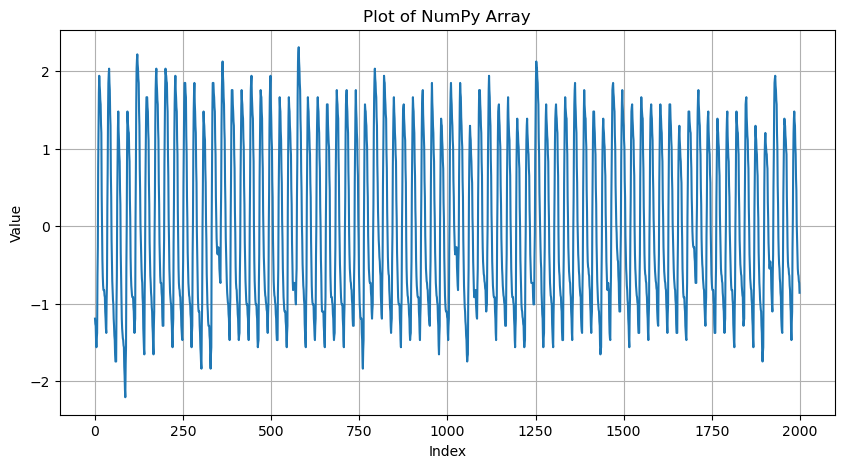

In [29]:
def plot_numpy_array(data, x_label='Index', y_label='Value', title='Plot of NumPy Array', figsize=(10,5)):
    """
    Plots a NumPy array using matplotlib.

    Parameters:
    - data (numpy.array): The data to plot.
    - x_label (str): Label for the X-axis.
    - y_label (str): Label for the Y-axis.
    - title (str): Title of the plot.
    """
    plt.figure(figsize=figsize)  # Adjust the size of the plot
    plt.plot(data, linestyle='-')  # Plot the data
    plt.title(title)  # Set the title of the plot
    plt.xlabel(x_label)  # Set the X-axis label
    plt.ylabel(y_label)  # Set the Y-axis label
    plt.grid(True)  # Enable grid for easier reading
    plt.show()  # Display the plot

#plot_numpy_array(ts[0:27*8], figsize = (10,5))
plot_numpy_array(ts[0:2000], figsize = (10,5))


In [30]:
len(data_MPlot.data_b)

8760

In [31]:
max_points = 5000
min_position = 0

In [33]:
data_MPlot.compute(
    mp_method           = 'stump', 
    #mp_method           = "scamp_naive" --> Devuelve siempre 0 en el ejemplo de Pulsus Raxodus | why?
    #dm_method           = 'stump'
    dm_method           = 'scamp',
    print_flag          = True,
    debug               = False,
    time_flag           = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    #x_min               = 200*4,
    #x_max               = 200*6,
    #y_min               = 0, 
    #y_max               = 200,
    max_points          = max_points,
    #nlens              = 5,
    subsequence_len     = 50, #1 heartbeat
    #provide_len        = True,
    provide_len         = False,
    downsample_flag     = True,
    min_lag             = 8,
    print_depth         = 1,
    threads             = 1,
    gpus                = []
)

MatrixProfilePlot | Compute | No range provided
MatrixProfilePlot | Compute | Range [0:8760, 0:8760]
[ MPlot | Compute ] | -->  Downsample 
[ MPlot | Compute ] | ---> Downsample TA to 0 : 8760
[ MPlot | Compute ] | Downsample TA ~ 8761 ---> 
[ MPlot | Compute ] |  --> Downsample TB 
[ MPlot | Compute ] | Downsample TB_paa ~ 8761 ---> 
[ MPlot | Compute ] |Downsample -->
MPlot | Compute | --> Ensure parameters 
MPlot | Compute | --> provide_len | data ~  (8760,)
MPlot | Compute | --> provide_len | Elif provide_len | TB_paa 8761
[ MPlot | Compute ] | Ensure Parameters TB_paa ~ 8761 ---> 
Ensure valid limits | Original [0, 8760]
Final [0, 8761]
Ensure valid limits | Original [0, 8760]
Final [0, 8761]
MatrixProfilePlot | Compute | Final Range [0:8761, 0:8761]
MPlot | Compute | --> Instantiate DM & MP | TA ~ 8761 | TB ~ 8761
MPlot | Compute | ... Checking inicializations ...
MP_AB self_join False
DM_AB self_join False
DM_AB ~ (0, 0)
MP_AB method: naive
DM_AB method: naive
MP_AB data_b ~ 876

In [ ]:
print(data_MPlot.DM_AB.shape)
print(data_MPlot.DM_AB.method)

In [34]:
#######
## CUIDADO PORQUE SCAMP NO SE DA CUENTA SI LAS GPUS ESTÁN PETADAS, TIRA MILLAS Y SACA TODO EL MP A 0.0
#######
print(len(ts))
print(len(data_MPlot.MP_AB.distances))
print(data_MPlot.MP_AB.distances)
print(data_MPlot.DM_AB.distances)
print(data_MPlot.mp_method)

8760
8711
[0.6391949175478758 0.6183840794313303 0.6140571246157576 ...
 0.6459235947359013 0.6838196309114927 0.714358063363988]
[[       inf        inf        inf ... 9.92815922 9.91539857 9.90809549]
 [       inf        inf        inf ... 9.94636089 9.92937001 9.91602821]
 [       inf        inf        inf ... 9.96763703 9.94789041 9.9302699 ]
 ...
 [9.92815922 9.94636089 9.96763703 ...        inf        inf        inf]
 [9.91539857 9.92937001 9.94789041 ...        inf        inf        inf]
 [9.90809549 9.91602821 9.9302699  ...        inf        inf        inf]]
stump


In [35]:
#| hide
print("MP_AB self_join", data_MPlot.MP_AB.self_join)
print("DM_AB self_join", data_MPlot.DM_AB.self_join)
print(f"DM_AB ~ {data_MPlot.DM_AB.shape}")
print("MP_AB method:", data_MPlot.MP_AB.method)
print("DM_AB method:", data_MPlot.DM_AB.method)

MP_AB self_join False
DM_AB self_join False
DM_AB ~ (8712, 8712)
MP_AB method: stump
DM_AB method: scamp


In [36]:
data_MPlot.DM_AB.distances.shape

(8712, 8712)

In [37]:
figsize = (10,10)
numerator = np.maximum(len(data_MPlot.DM_AB.distances[0]), 1)
print("numerator", numerator)
denominator = np.maximum(1, int(figsize[0] * 2))
print("denominator", denominator)

numerator 8712
denominator 20


In [38]:
x_labels_count = np.maximum(
    1, 
    len(data_MPlot.DM_AB.distances[0]) // np.maximum(1, int(figsize[0] * 2))
)
start = 0
stop = len(data_MPlot.DM_AB.distances[0])
step = (stop-start)//x_labels_count
step = x_labels_count
print("start", start, "stop", stop, "step", x_labels_count)
np.arange(start, stop, step)

start 0 stop 8712 step 435


array([   0,  435,  870, 1305, 1740, 2175, 2610, 3045, 3480, 3915, 4350,
       4785, 5220, 5655, 6090, 6525, 6960, 7395, 7830, 8265, 8700])

Observando en [MPlots-pdf-Catalog](https://drive.google.com/file/d/1fjWUzVQf-8XmS5epDa_ulm4-bDX51Vxv/view) hay un motif de longitud 187 en aproximadamente la posicion:

In [39]:
fraction = 205000/4
print(fraction)
approximated_position_in_eamonn_plot = fraction + (2 * fraction / 3)
print(f"Approximated position in eammon's plot {approximated_position_in_eamonn_plot}")

51250.0
Approximated position in eammon's plot 85416.66666666666


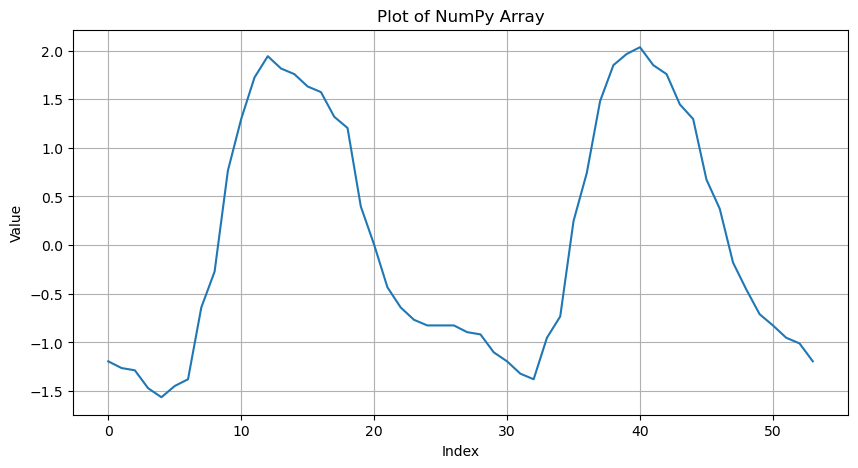

In [40]:
#plot_numpy_array(ts[81000:102500], figsize = (30,5))
#plot_numpy_array(ts[data_MPlot.x_min:data_MPlot.x_max], figsize = (15,5))
#plot_numpy_array(ts, figsize = (10,5))
plot_numpy_array(ts[0:27*2], figsize = (10,5))

Max points: 3000


Before: Pos 0 Add 0
Plot Interactive | After: Pos 0 Selected index 5816
Plot Interactive | Distances:  [0.6391949175478758 0.6183840794313303 0.6140571246157576 ...
 0.6459235947359013 0.6838196309114927 0.714358063363988]
Plot Interactive | Window [4316, 7316]


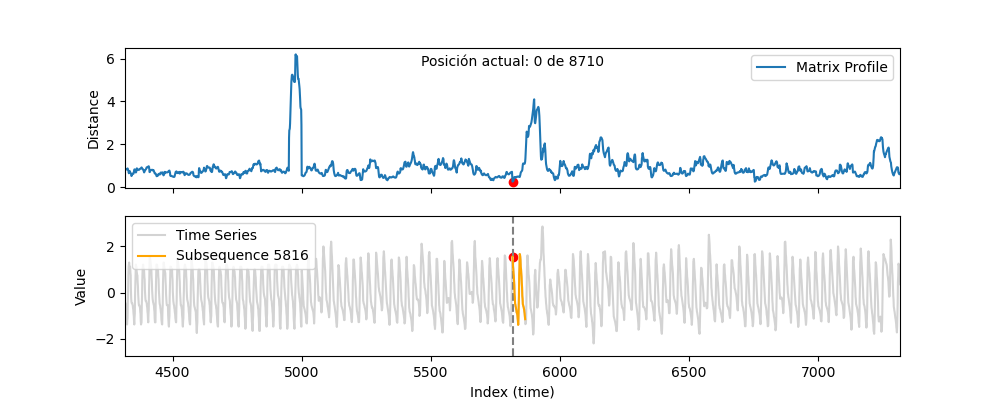

In [41]:
%matplotlib widget
#data_MPlot.MP_AB.max_points = 100+data_MPlot.subsequence_len
max_points = 3000
print(f"Max points: {max_points}")
data_MPlot.MP_AB.max_points = max_points
data_MPlot.MP_AB.plot_interactive(print_flag = True)

In [42]:
print(f"{data_MPlot.x_min}, {data_MPlot.x_max}")

0, 8761


In [43]:
data_MPlot.DM_AB.distances.shape

(8712, 8712)

In [44]:
data_MPlot.x_min

0

In [45]:
xmin = 600
xmax = 1200
print("Original range:", data_MPlot.x_min, data_MPlot.x_max)
xstart = xmin - data_MPlot.x_min
xend = np.minimum( xmax - data_MPlot.x_min, data_MPlot.DM_AB.distances.shape[1])
print(xstart, xend)

Original range: 0 8761
600 1200


In [46]:
data_MPlot.DM_AB.distances.shape

(8712, 8712)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


--> Plotting MP
tx_start 0.5 tx_stop 8762 tx_step 438
ty_start 0.5 ty_stop 8762 ty_step 438
MPlot | Plot DM | ... No Adapt labels ...
MPlot | Plot DM | x_ticks [5.0000e-01 4.3850e+02 8.7650e+02 1.3145e+03 1.7525e+03 2.1905e+03
 2.6285e+03 3.0665e+03 3.5045e+03 3.9425e+03 4.3805e+03 4.8185e+03
 5.2565e+03 5.6945e+03 6.1325e+03 6.5705e+03 7.0085e+03 7.4465e+03
 7.8845e+03 8.3225e+03 8.7605e+03]
MPlot | Plot DM | y_ticks [5.0000e-01 4.3850e+02 8.7650e+02 1.3145e+03 1.7525e+03 2.1905e+03
 2.6285e+03 3.0665e+03 3.5045e+03 3.9425e+03 4.3805e+03 4.8185e+03
 5.2565e+03 5.6945e+03 6.1325e+03 6.5705e+03 7.0085e+03 7.4465e+03
 7.8845e+03 8.3225e+03 8.7605e+03]
MPlot | Plot DM | data ~  (8760,)
MPlot | Plot DM | DM_AB ~  (8712, 8712)
MPlot | Plot DM | DM_AB[0:8761] ~ (8712, 8712)
MPlot | Plot DM | DM_AB[0:8761] ~ (8712, 8712)
Plotting as MATLAB


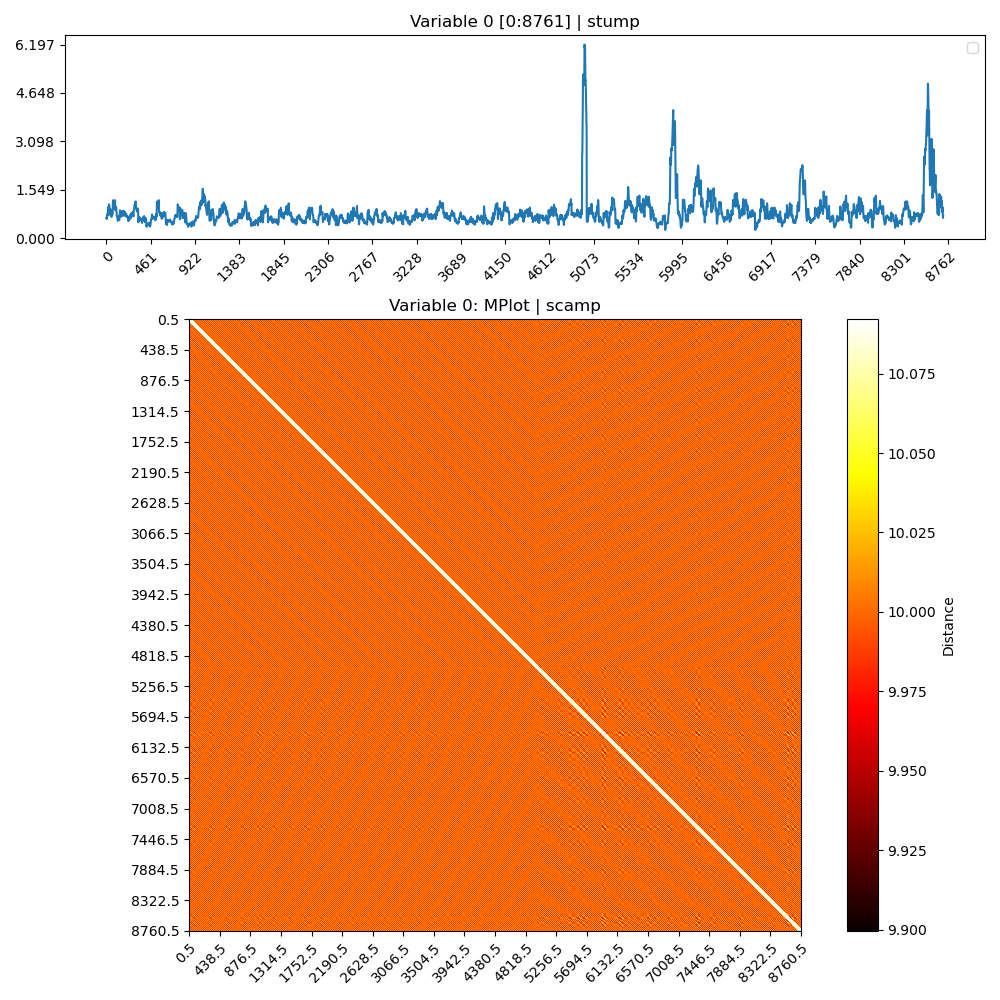

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [47]:
data_MPlot.plot(
    ts_name     = 'Variable 0',
    figsize     = (10,10),
    print_flag  = True,
    less_labels = True,
    debug_flag  = True,
    dm_filter   = mplots.threshold_interval,
    th_min      = 7.5,
    th_max      = np.inf,
    include_min = False,
    include_max = False,
    MPlot_title = 'Variable 0: MPlot | ' + data_MPlot.DM_AB.method
)

In [48]:
data_MPlot.plot_as_matlab

True

In [49]:
x_min = 10000/step
x_max = 12000/step
y_min = 0/step
y_max = 2000/step


print(f"X({x_min}, {x_max}) Y({y_min}, {y_max})")

X(22.988505747126435, 27.586206896551722) Y(0.0, 4.597701149425287)


In [50]:
"""
x_min_zoom = mplots.zoom_index(x_min, len(data_MPlot.data), data_MPlot.x_min, data_MPlot.x_max)
x_max_zoom = mplots.zoom_index(x_max, len(data_MPlot.data), data_MPlot.x_min, data_MPlot.x_max)
y_min_zoom = mplots.zoom_index(y_min, len(data_MPlot.data_b), data_MPlot.y_min, data_MPlot.y_max)
y_max_zoom = mplots.zoom_index(y_max, len(data_MPlot.data_b), data_MPlot.y_min, data_MPlot.y_max)
"""
x_min_zoom = mplots.zoom_index(x_min, len(data_MPlot.data), len(data_MPlot.data_paa))
x_max_zoom = mplots.zoom_index(x_max, len(data_MPlot.data), len(data_MPlot.data_paa))
y_min_zoom = mplots.zoom_index(y_min, len(data_MPlot.data_b), len(data_MPlot.data_b_paa))
y_max_zoom = mplots.zoom_index(y_max, len(data_MPlot.data_b), len(data_MPlot.data_b_paa))

print(f"Original limits: X(0, {len(data_MPlot.data)}) Y(0, {len(data_MPlot.data_b)})")
print(f"Final limits: X({data_MPlot.x_min}, {data_MPlot.x_max}) Y({data_MPlot.y_min}, {data_MPlot.y_max})")

print(f"X({x_min},{x_max}) Y({y_min},{y_max})")
print(f"ZX({x_min_zoom}, {x_max_zoom}) ZY({y_min_zoom}, {y_max_zoom})")


Original limits: X(0, 8760) Y(0, 8760)
Final limits: X(0, 8761) Y(0, 8761)
X(22.988505747126435,27.586206896551722) Y(0.0,4.597701149425287)
ZX(23, 28) ZY(0, 5)


In [51]:
#x   = 12000
#zx  = mplots.zoom_index(x, len(data_MPlot.data), data_MPlot.x_min, data_MPlot.x_max)
#rzx = mplots.restore_index(zx, data_MPlot.x_min, data_MPlot.x_max, len(data_MPlot.data))
#print(f"X({x}) ZX({zx}) RZX({rzx})")


In [52]:
#### Algo no cuadra con restore index
""" 
print(mplots.restore_index(x_min_zoom, len(data_MPlot.data), data_MPlot.x_min, data_MPlot.x_max))
print(mplots.restore_index(x_max_zoom, len(data_MPlot.data), data_MPlot.x_max, data_MPlot.x_max))
print(mplots.restore_index(y_min_zoom, len(data_MPlot.data_b), data_MPlot.y_min, data_MPlot.y_max))
print(mplots.restore_index(y_max_zoom, len(data_MPlot.data_b), data_MPlot.y_max, data_MPlot.y_max))
"""
print(mplots.restore_index(x_min_zoom, len(data_MPlot.data), len(data_MPlot.data_paa)))
print(mplots.restore_index(x_max_zoom, len(data_MPlot.data), len(data_MPlot.data_paa)))
print(mplots.restore_index(y_min_zoom, len(data_MPlot.data_b), len(data_MPlot.data_b_paa)))
print(mplots.restore_index(y_max_zoom, len(data_MPlot.data_b), len(data_MPlot.data_b_paa)))

23
28
0
5


In [53]:
data_MPlot.DM_AB.distances.shape

(8712, 8712)

In [54]:
def threshold_interval_black_and_white(
    data,
    th_min, 
    th_max, 
    include_min,
    include_max
):
    result = np.array(data)
    if include_min:
        result = np.where(result > th_min, result, np.inf)
    else:
        result = np.where(result >= th_min, result, np.inf)
    if include_max:
        result = result < th_max
    else:
        result = result <= th_max
    return result
        

In [55]:
np.where(data_MPlot.DM_AB.distances < np.inf, data_MPlot.DM_AB.distances, -1)

array([[-1.        , -1.        , -1.        , ...,  9.92815922,
         9.91539857,  9.90809549],
       [-1.        , -1.        , -1.        , ...,  9.94636089,
         9.92937001,  9.91602821],
       [-1.        , -1.        , -1.        , ...,  9.96763703,
         9.94789041,  9.9302699 ],
       ...,
       [ 9.92815922,  9.94636089,  9.96763703, ..., -1.        ,
        -1.        , -1.        ],
       [ 9.91539857,  9.92937001,  9.94789041, ..., -1.        ,
        -1.        , -1.        ],
       [ 9.90809549,  9.91602821,  9.9302699 , ..., -1.        ,
        -1.        , -1.        ]])

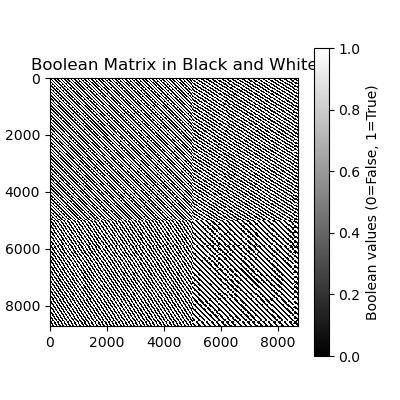

In [56]:
threshold_scamp = 10
threshold_stump = 10
data = threshold_interval_black_and_white(data_MPlot.DM_AB.distances, threshold_stump,np.inf,True, True)
#print(data)
# Mostrar un trozo de la matriz booleana
plt.figure(figsize=(4, 4))
plt.imshow(data, cmap='gray', interpolation='none')
plt.colorbar(label='Boolean values (0=False, 1=True)')
plt.title('Boolean Matrix in Black and White')
plt.show()

In [57]:
data

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [58]:
data.shape

(8712, 8712)

In [59]:
y = (5000,6000+1)
x = (0,1000+1)

xmin = x[0]
xmax = x[1]
ymin = y[0]
ymax = y[1]

Threshold:  10


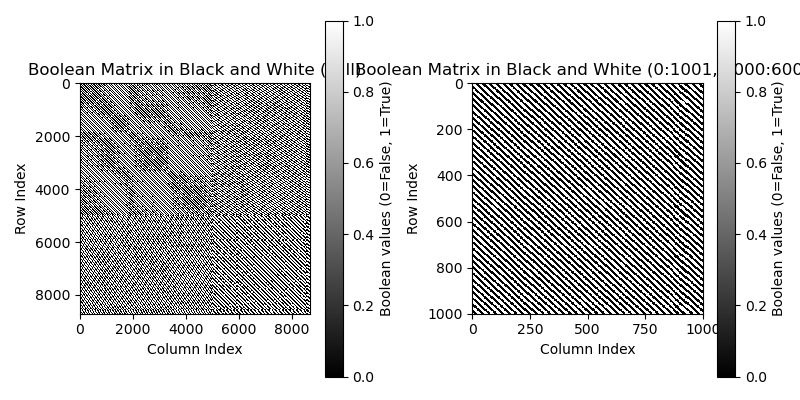

In [73]:
threshold_scamp = 10
threshold_stump = 7.5
threshold = thresgold_stump if data_MPlot.DM_AB.method == 'stump' else threshold_scamp
print("Threshold: ", threshold)
data = threshold_interval_black_and_white(data_MPlot.DM_AB.distances, threshold,np.inf,True, True)

# Crear una figura con dos subplots uno al lado del otro
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Mostrar la matriz completa
axes[0].imshow(data, cmap='gray', interpolation='none')
axes[0].set_title('Boolean Matrix in Black and White (Full)')
axes[0].set_xlabel('Column Index')
axes[0].set_ylabel('Row Index')
plt.colorbar(axes[0].imshow(data, cmap='gray', interpolation='none'), ax=axes[0], label='Boolean values (0=False, 1=True)')

# Mostrar el trozo de la matriz
axes[1].imshow(data[xmin:xmax, ymin:ymax], cmap='gray', interpolation='none')
axes[1].set_title(f'Boolean Matrix in Black and White ({xmin}:{xmax}, {ymin}:{ymax})')
axes[1].set_xlabel('Column Index')
axes[1].set_ylabel('Row Index')
plt.colorbar(axes[1].imshow(data[xmin:xmax, ymin:ymax], cmap='gray', interpolation='none'), ax=axes[1], label='Boolean values (0=False, 1=True)')

# Ajustar el layout
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MPlot | Plot DM | DM_AB[5000:6000] ~ (1000, 8712)
Plotting as MATLAB


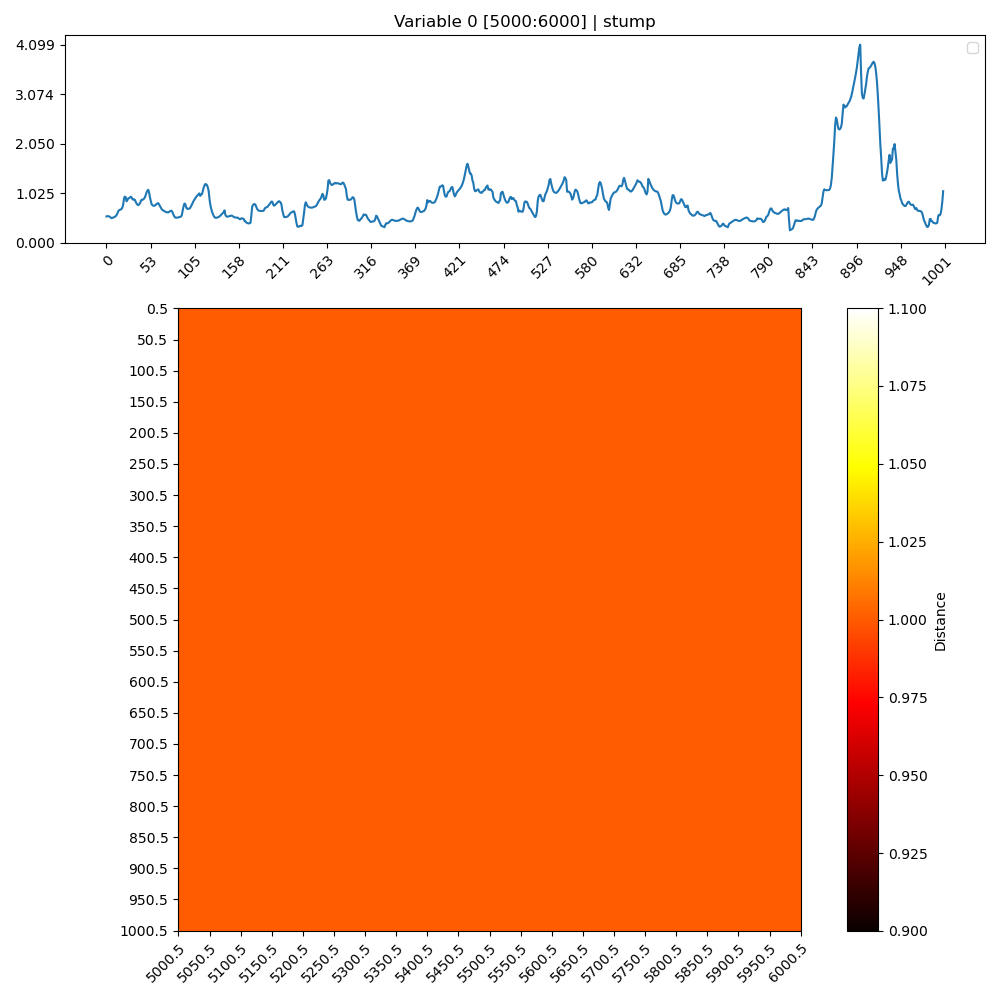

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [61]:
data_MPlot.plot(
    ts_name     = 'Variable 0',
    figsize     = (10,10),
    print_flag  = True,
    less_labels = True,
    x_min       = 5000,
    x_max       = 6000,
    y_min       = 0,
    y_max       = 1000,
    dm_filter   = threshold_interval_black_and_white,
    th_min      = 7,
    th_max      = np.inf,
    include_min = False,
    include_max = False
)

In [62]:
##... Insectos
fraction = 205000/4
print(fraction)
approximated_position_in_eamonn_plot = fraction + (2 * fraction / 3)
print(f"Approximated position in eammon's plot {approximated_position_in_eamonn_plot}")

51250.0
Approximated position in eammon's plot 85416.66666666666


In [63]:
data_MPlots.DM_AB.shape

NameError: name 'data_MPlots' is not defined